In [177]:
import numpy as np
from qutip_qtrl import fidcomp
from qutip import *
# matplotlibで日本語表示できるようにします。
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "MS Gothic"

# 開発用ノートブック
ここでは評価関数をカスタムできるGRAPEの実装を目標にしています。後半では勾配の計算の仕方や学習と最適化のルールもカスタムできるようにする予定です。
## カスタム評価関数の実装
フィデリティに加えて、パルエネルギーでペナルティを加えてみる。

- $F_{error} = 1 - \frac{1}{d} \|{Tr(U_{tgt}^{\dagger}U(T))}\|$
- にパルスエネルギー($\Sigma u_{jk}^2$)のペナルティをハイパーパラメータ$\lambda=10^{-2}$で加える

$_{min}J=F_{error}+\lambda E_{pulse}$

In [178]:
from qutip.control.grape import _overlap

In [179]:
# FidCompTraceDiffApproxを継承
class EnergyWeightedPSU(fidcomp.FidCompTraceDiffApprox):
    l = 1e-5

    # 評価関数のみを上書き
    def get_fid_err(self):

        if not self.fidelity_current:
            dyn = self.parent
            d = dyn.target.shape[0]
            dyn.compute_evolution()
            
            U_T = dyn._fwd_evo[dyn.num_tslots]
            U_T = Qobj(U_T, dims=dyn.target.dims)
            #print(dyn.target.dag(), dyn.target.dag().shape, dyn.target.dag().type)
            #print(U_T, U_T.shape, U_T.type)
            F = (dyn.target.dag() * U_T).tr() / 4
            eps = 1 - F.real

            # パルスエネルギー (制御振幅幅の二乗の時間積分)
            amps = dyn.ctrl_amps
            dt = dyn.tau[0]
            E = dt * np.sum(amps**2)

            self.fid_err = (eps + self.l * E)
            self.fidelity_current = True

        return self.fid_err

In [180]:
# single_qubit_opt.py --------------------------------------------------
import numpy as np
from qutip import identity, sigmax, sigmay, basis
from qutip_qtrl import pulseoptim  # さきほど定義したクラス

# --- 系の定義 ---------------------------------------------------------
H_d   = 0 * sigmax()                  # ドリフト 0 としておく
H_c   = [sigmax(), sigmay()]          # X, Y の 2 制御
U_0   = identity(2)                   # 初期ユニタリ
U_tgt = (-1j * np.pi/4 * sigmay()).expm()   # R_y(π/2)

n_ts, evo_time = 100, 10.0

# --- 初期制御振幅を設定 ----------------------------------------------
init_amps = np.random.uniform(-1, 1, size=(n_ts, len(H_c)))  # 初期振幅を小さく

# --- Optimizer を生成（fid_type はダミーで OK） -----------------------
optim = pulseoptim.create_pulse_optimizer(
    H_d, H_c, U_0, U_tgt,
    num_tslots=n_ts, evo_time=evo_time,
    fid_type='TRACEDIFF',             # 後で差し替える
    amp_lbound=-5.0, amp_ubound=5.0,
    optim_method='Nelder-mead'               # より効率的な最適化手法に変更
)

# --- FidelityComputer を差し替え -------------------------------------
dyn = optim.dynamics
dyn.initialize_controls(init_amps)
dyn.fid_computer = EnergyWeightedPSU(dyn)
dyn.fid_computer.init_comp()

# --- 最適化実行 -------------------------------------------------------
result = optim.run_optimization()

print(f'final cost   : {result.fid_err:.3e}')
print(f'gate fidelity: {1-result.fid_err:.6f}')  # ペナルティ項が小さいとき
print(f'pulse energy: {np.sum(result.final_amps**2) * dyn.tau[0]:.3e}')  # パルスエネルギー

final cost   : 6.432e-01
gate fidelity: 0.356820
pulse energy: 5.709e+00


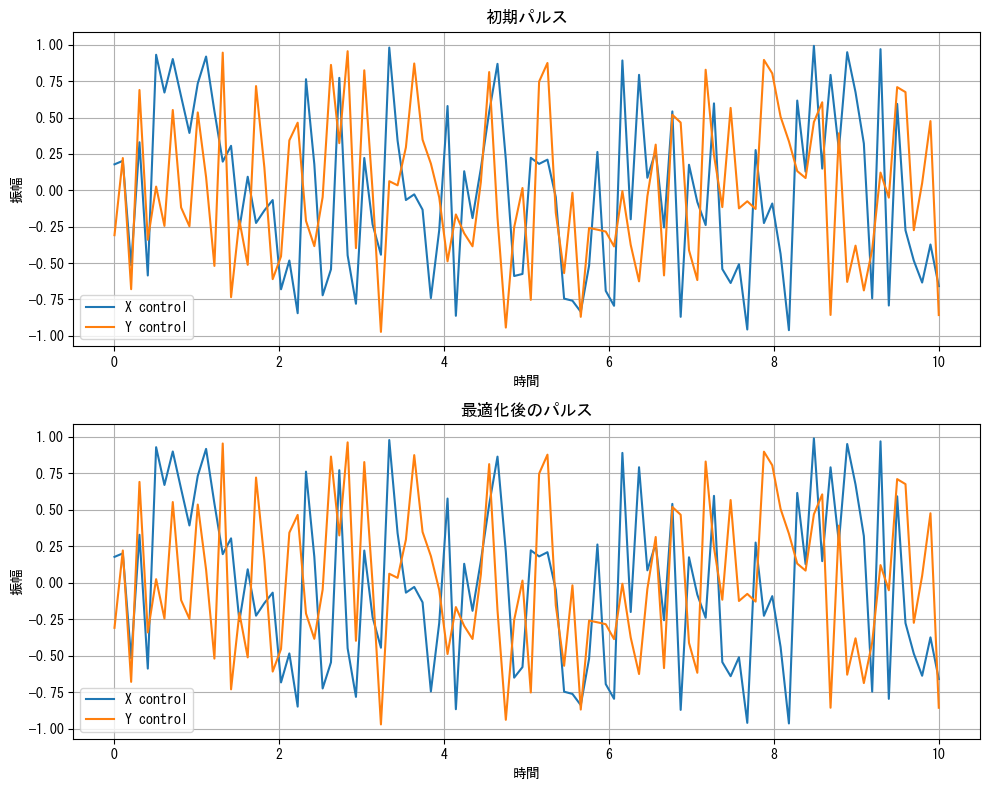

In [181]:
# --- 最適化前後のパルスを比較プロット -----------------------------------

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
t = np.linspace(0, evo_time, n_ts)

# 初期パルス
ax1.plot(t, init_amps[:, 0], label='X control')
ax1.plot(t, init_amps[:, 1], label='Y control')
ax1.set_title('初期パルス')
ax1.set_xlabel('時間')
ax1.set_ylabel('振幅')
ax1.legend()
ax1.grid(True)

# 最適化後のパルス
optimized_amps = result.final_amps
ax2.plot(t, optimized_amps[:, 0], label='X control')
ax2.plot(t, optimized_amps[:, 1], label='Y control')
ax2.set_title('最適化後のパルス')
ax2.set_xlabel('時間')
ax2.set_ylabel('振幅')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [182]:
from qutip import sigmax, sigmaz, tensor, identity
from qutip.control import pulseoptim

# 例：1量子ビット π/2 回転
H_drift = 2*np.pi*0.5*sigmaz()          # ドリフト
H_ctrls = [2*np.pi*0.25*sigmax()]       # 制御項
U_target = (-1j*np.pi/4*sigmax()).expm()

result = pulseoptim(H_drift, H_ctrls, identity(2), U_target,
                    n_ts=100, evo_time=1.0,
                    amp_lbound=-5.0, amp_ubound=5.0,
                    fid_err_targ=1e-4, max_iter=200)
print("最終フィデリティ:", 1-result.fid_err)

TypeError: 'module' object is not callable